In [63]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

# Compartments & Saddleplots

Welcome to the compartments and saddleplot notebook! 

This notebook illustrates cooltools functions used for investigating chromosomal compartments, visible as plaid patterns in mammalian interphase contact frequency maps.

These plaid patterns reflect tendencies of chromosome regions to make more frequent contacts with regions of the same type: active regions have increased contact frequency with other active regions, and intactive regions tend to contact other inactive regions more frequently. The strength of compartmentalization has been show to vary through the cell cycle, across cell types, and after degredation of components of the cohesin complex. 

In this notebook we:

* obtain compartment profiles using eigendecomposition
* calculate and visualize strength of compartmentalization using saddleplots

In [259]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import pandas as pd
import os, subprocess

In [4]:
plt.style.use("bmh")
plt.rcParams.update({"figure.figsize" : (12, 8),
                     "axes.facecolor" : "white",
                     "axes.edgecolor":  "black"})

In [5]:
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting
from cooltools.lib import numutils

In [6]:
# download test data
# this file is 145 Mb, and may take a few seconds to download
import cooltools
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')    
print(cool_file)

./test.mcool


## Calculating per-chromosome compartmentalization

We first load the Hi-C data at 100 kbp resolution. 

Note that the current implementation of eigendecomposition in cooltools assumes that individual regions can be held in memory-- for hg38 at 100kb this is either a 2422x2422 matrix for chr2, or a 3255x3255 matrix for the full cooler here.

In [7]:
clr = cooler.Cooler('test.mcool::resolutions/100000')

Since the orientation of eigenvectors is determined up to a sign, the convention for Hi-C data anaylsis is to orient eigenvectors to be positively correlated with a binned profile of GC content as a 'phasing track'. 

In humans and mice, GC content is useful for phasing because it typically has a strong correlation at the 100kb-1Mb bin level with the eigenvector. In other organisms, other phasing tracks have been used to orient
eigenvectors from Hi-C data. 

For other data analyses, different conventions are used to consistently orient eigenvectors. For example, spectral clustering as implemented in [scikit-learn](
https://github.com/scikit-learn/scikit-learn/blob/03245ee3afe5ee9e2ff626e2290f02748d95e497/sklearn/utils/extmath.py#L1041) orients vectors such that the absolute maximum element of each vector is positive. 

In [8]:
## fasta sequence is required for calculating binned profile of GC conent
if not os.path.isfile('./hg38.fa'):
    ## note downloading a ~1Gb file can take a minute
    subprocess.call('wget https://hgdownload.cse.ucsc.edu/goldenpath/hg38/bigZips/hg38.fa.gz', shell=True)
    subprocess.call('gunzip hg38.fa.gz', shell=True)

In [9]:
import bioframe
bins = clr.bins()[:]
hg38_genome = bioframe.load_fasta('./hg38.fa');
## note the next command may require installing pysam
gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], hg38_genome)
gc_cov.to_csv('hg38_gc_cov_100kb.tsv',index=False,sep='\t')
display(gc_cov)

,chrom,start,end,GC
0,chr2,0,100000,0.435867
1,chr2,100000,200000,0.409530
2,chr2,200000,300000,0.421890
3,chr2,300000,400000,0.431870
4,chr2,400000,500000,0.458610
...,...,...,...,...
3250,chr17,82800000,82900000,0.528210
3251,chr17,82900000,83000000,0.518530
3252,chr17,83000000,83100000,0.561450
3253,chr17,83100000,83200000,0.535119


Cooltools also allows a view to be passed for eigendecomposition to limit to a certain set of regions. The following code creates the simplest view, of the two chromosomes in this cooler.

In [10]:
view_df = pd.DataFrame({'chrom': clr.chromnames,
                        'start': 0,
                        'end': clr.chromsizes.values,
                        'name': clr.chromnames}
                      )
display(view_df)

,chrom,start,end,name
0,chr2,0,242193529,chr2
1,chr17,0,83257441,chr17


To capture the pattern of compartmentalization within-chromosomes, in cis, cooltools `eigs_cis` first removes
the dependence of contact frequency by distance, and then performs eigenedecompostion. 

In [11]:
# obtain first 3 eigenvectors
cis_eigs = cooltools.eigs_cis( 
                        clr, 
                        gc_cov, 
                        view_df=view_df, 
                        n_eigs=3,
                        )

# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors
eigenvector_track = cis_eigs[1][['chrom','start','end','E1']]

In [248]:
def plot_mat_vecs(ax, mat, vec, vmin=0.1, vmax=1.9, n="linear"):
    #
    ax.imshow(
        mat,
        cmap="coolwarm",
        norm=colors.Normalize(vmin,vmax) if n=="linear" else colors.LogNorm(vmin,vmax),
        interpolation="none"
    )
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    if vec is not None:
        divider = make_axes_locatable(ax)
        #
        ax2 = divider.append_axes("top", size="20%", pad=0.25, sharex=ax)
        ax2.plot(vec,linewidth=0.5)
        ax2.fill_between(np.arange(vec.size), vec, np.median(vec), where=(vec >=np.median(vec)),color="red")
        ax2.fill_between(np.arange(vec.size), vec, np.median(vec), where=(vec <=np.median(vec)),color="blue")
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.grid(False)
        ax2.set_frame_on(False)
        ax2.set_xlim(0,vec.size)
        ymin, ymax = ax2.get_ylim()

        ax1 = divider.append_axes("left", size="20%", pad=0.25, sharey=ax)
        ax1.plot(vec,np.arange(vec.size),linewidth=0.5)
        ax1.fill_betweenx(np.arange(vec.size), vec, np.median(vec), where=(vec >=np.median(vec)),color="red")
        ax1.fill_betweenx(np.arange(vec.size), vec, np.median(vec), where=(vec <=np.median(vec)),color="blue")
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.grid(False)
        ax1.set_frame_on(False)
        ax1.set_xlim((ymax, ymin))
        ax1.set_ylim(vec.size,0)


/tmp/ipykernel_8122/2074284742.py:35: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  _mat_vec = np.sum(np.outer(eigvecs[i][fridx:toidx],eigvecs[i][fridx:toidx])*np.sign(eigvals[i]) for i in [0,1,2,3])


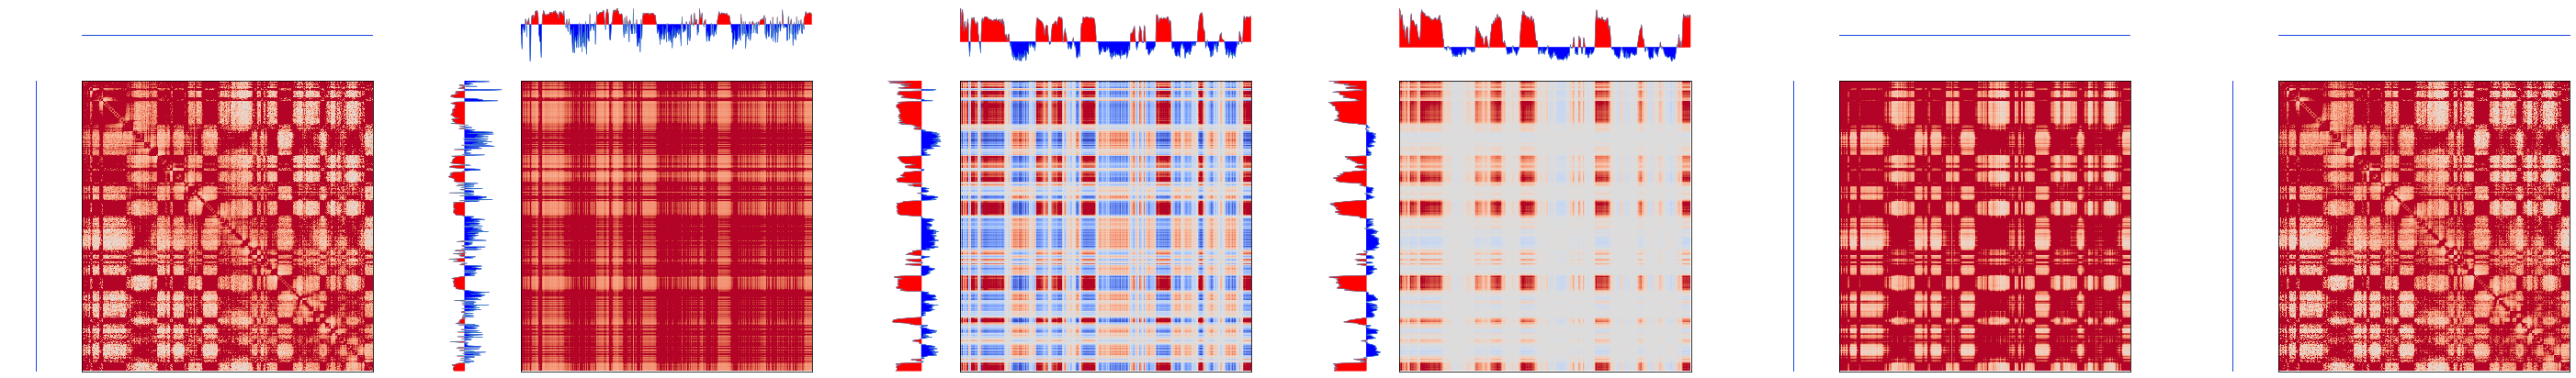

In [251]:
_region = view_df.iloc[0,:3].to_numpy()
A = clr.matrix().fetch(_region)
ignore_diags=2
clip_percentile=98
# n_eigs=3,phasing_track=None, sort_metric=None
# masking , masking, masking ...
A = np.array(A)
A[~np.isfinite(A)] = 0
mask = A.sum(axis=0) > 0
# ignore diags ...
for d in range(-ignore_diags + 1, ignore_diags):
    numutils.set_diag(A, 1.0, d)
# get Observed/Expected ...
OE, _, _, _ = numutils.observed_over_expected(A, mask)
# # clip outliers
OE = np.clip(OE, 0, np.percentile(OE[mask, :][:, mask], clip_percentile))
# # subtract 1.0 ?
# OE -= 1.0  #np.median(OE[mask, :][:, mask])
OE_tmp = OE[mask,:][:,mask].copy()
eigvecs, eigvals = numutils.get_eig(OE_tmp, 9, False)
eigvecs /= np.sqrt(np.nansum(eigvecs ** 2, axis=1))[:, None]
eigvecs *= np.sqrt(np.abs(eigvals))[:, None]

##########################################################################################
# plot several of the eigs here ...
##########################################################################################
fridx,toidx = 0,500
_matrix = OE_tmp[fridx:toidx,fridx:toidx]
fig,axs = plt.subplots(ncols=6,**dict(figsize=(50,9),facecolor="white"))
plot_mat_vecs(axs[0], _matrix, np.zeros(eigvecs[i][fridx:toidx].size) , vmin=-1,vmax=1)
for i in [0,1,2]:
    _vector = eigvecs[i][fridx:toidx]
    plot_mat_vecs(axs[i+1], np.outer(_vector, _vector), _vector, vmin=-1,vmax=1)
##############################################################
_mat_vec = np.sum(np.outer(eigvecs[i][fridx:toidx],eigvecs[i][fridx:toidx])*np.sign(eigvals[i]) for i in [0,1,2,3])
plot_mat_vecs(axs[4], _mat_vec,  np.zeros(eigvecs[i][fridx:toidx].size), vmin=-1,vmax=1)
plot_mat_vecs(axs[5], _matrix,  np.zeros(eigvecs[i][fridx:toidx].size), vmin=-1,vmax=1)



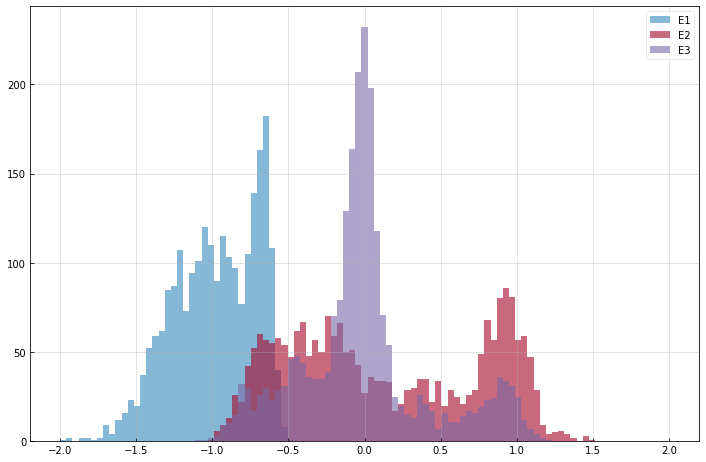

In [254]:
plt.figure(facecolor="white")
bins = np.linspace(-2,2,100)
plt.hist(eigvecs[0],bins=bins, alpha=0.6,label=f"E{0+1}");
plt.hist(eigvecs[1],bins=bins, alpha=0.6,label=f"E{1+1}");
plt.hist(eigvecs[2],bins=bins, alpha=0.6,label=f"E{2+1}");
# plt.hist(eigvecs[3],bins=bins, alpha=0.6,label=f"E{3+1}");
plt.legend()

/tmp/ipykernel_8122/73781281.py:36: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  _mat_vec = np.sum(np.outer(eigvecs[i][fridx:toidx],eigvecs[i][fridx:toidx])*np.sign(eigvals[i]) for i in [0,1,2,3])


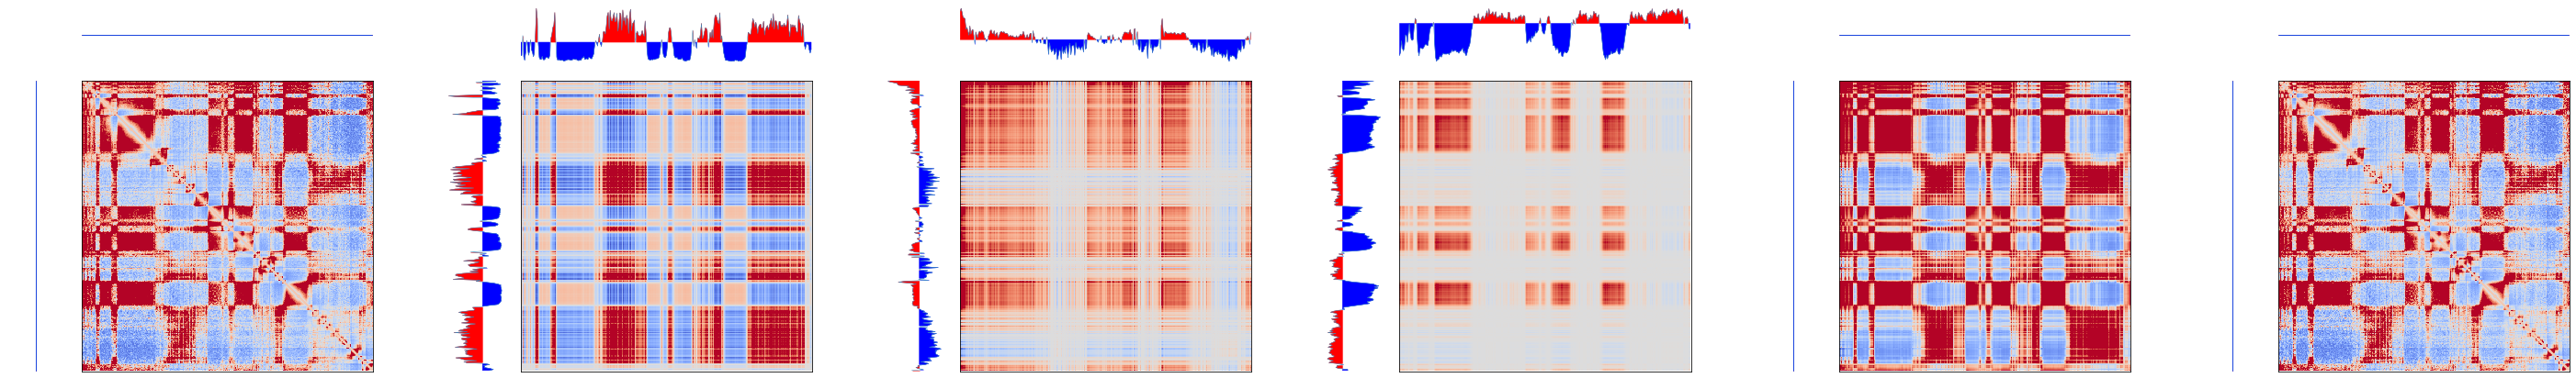

In [258]:
_region = view_df.iloc[0,:3].to_numpy()
A = clr.matrix().fetch(_region)
ignore_diags=2
clip_percentile=98
# n_eigs=3,phasing_track=None, sort_metric=None
# masking , masking, masking ...
A = np.array(A)
A[~np.isfinite(A)] = 0
mask = A.sum(axis=0) > 0
# ignore diags ...
for d in range(-ignore_diags + 1, ignore_diags):
    numutils.set_diag(A, 1.0, d)
# get Observed/Expected ...
OE, _, _, _ = numutils.observed_over_expected(A, mask)
# # clip outliers
OE = np.clip(OE, 0, np.percentile(OE[mask, :][:, mask], clip_percentile))
# # subtract 1.0 ?
OE -= np.median(OE[mask, :][:, mask])

OE_tmp = OE[mask,:][:,mask].copy()
eigvecs, eigvals = numutils.get_eig(OE_tmp, 9, False)
eigvecs /= np.sqrt(np.nansum(eigvecs ** 2, axis=1))[:, None]
eigvecs *= np.sqrt(np.abs(eigvals))[:, None]

##########################################################################################
# plot several of the eigs here ...
##########################################################################################
fridx,toidx = 0,300
_matrix = OE_tmp[fridx:toidx,fridx:toidx]
fig,axs = plt.subplots(ncols=6,**dict(figsize=(50,9),facecolor="white"))
plot_mat_vecs(axs[0], _matrix, np.zeros(eigvecs[i][fridx:toidx].size) ,vmin=-1,vmax=1)
for i in [0,1,2]:
    _vector = eigvecs[i][fridx:toidx]
    plot_mat_vecs(axs[i+1], np.outer(_vector, _vector)*np.sign(eigvals[i]), _vector,vmin=-1,vmax=1)
##############################################################
_mat_vec = np.sum(np.outer(eigvecs[i][fridx:toidx],eigvecs[i][fridx:toidx])*np.sign(eigvals[i]) for i in [0,1,2,3])
plot_mat_vecs(axs[4], _mat_vec,  np.zeros(eigvecs[i][fridx:toidx].size),vmin=-1,vmax=1)
plot_mat_vecs(axs[5], _matrix,  np.zeros(eigvecs[i][fridx:toidx].size),vmin=-1,vmax=1)



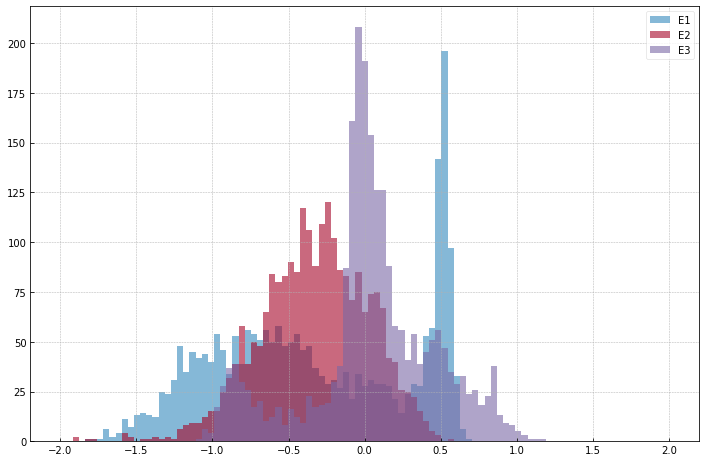

In [256]:
plt.figure(facecolor="white")
bins = np.linspace(-2,2,100)
plt.hist(eigvecs[0],bins=bins, alpha=0.6,label=f"E{0+1}");
plt.hist(eigvecs[1],bins=bins, alpha=0.6,label=f"E{1+1}");
plt.hist(eigvecs[2],bins=bins, alpha=0.6,label=f"E{2+1}");
# plt.hist(eigvecs[3],bins=bins, alpha=0.6,label=f"E{3+1}");
plt.legend()

Plotting the first eigenvector next to the Hi-C map allows us to see how this captures the plaid pattern. 

To better visualize this relationship, we overlay the map with a binary segmentation of the eigenvector. Eigenvectors can be segmented by a variety of methods. The simplest segmentation, shown here, is to simply binarize eigenvectors, and term everything above zero the "A-compartment" and everything below 0 the "B-compartment".


In [392]:
cvd = cooltools.expected_cis(
        clr=clr,
        view_df=view_df,
)


Q_LO = 0.025 # ignore 2.5% of genomic bins with the lowest E1 values
Q_HI = 0.975 # ignore 2.5% of genomic bins with the highest E1 values
# N_GROUPS = 38 # divide remaining 95% of the genome into 38 equisized groups, 2.5% each
N_GROUPS = 5 # divide remaining 95% of the genome into 38 equisized groups, 2.5% each


In [394]:
eigtrack = eigenvector_track.iloc[:len(eigvecs[0])].copy()

# digitize track 
# eigtrack.iloc[:len(eigvecs[0])]
eigtrack["E1"] = eigvecs[0]
digitized_track, binedges = cooltools.digitize(
    eigtrack, n_bins=5, vrange=None, qrange=(Q_LO,Q_HI)
)

# generate saddles-plots
interaction_sum, interaction_count =  cooltools.saddle(
        clr,
        cvd,
        eigenvector_track,
        'cis',
        n_bins=N_GROUPS,
        qrange=(Q_LO,Q_HI),
        view_df=view_df
)

In [389]:
def vecvalue_tospans(vec,value):
    """
    turn indices of elements where vec==value to
    spans of indices for axvspan visualization
    """
    _vec = vec.to_numpy().flatten()
    value_idxs = np.argwhere(_vec==value).flatten()
    
    # diff of matches indices - to get indices where "transition" happens
    diff_vec = np.diff(value_idxs)
    msk1 = np.r_[diff_vec, 1] != 1
    msk2 = np.r_[1, diff_vec] != 1
    
    # span borders d2-froms, d1-tos ...
    d1 = np.r_[value_idxs[msk1][1:], value_idxs[-1]]  # add last value here
    d2 = value_idxs[msk2]
    
    # return list of zipped spans
    return list( zip(d2,d1) )
    
    

In [378]:
import matplotlib.patches as patches

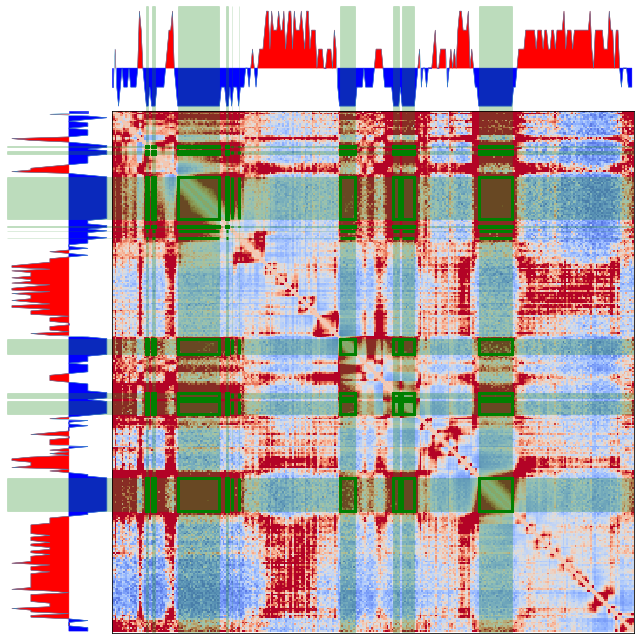

In [391]:
##########################################################################################
# plot several of the eigs here ...
##########################################################################################
fridx,toidx = 0,300
_matrix = OE_tmp[fridx:toidx,fridx:toidx]
fig,axs = plt.subplots(ncols=1, tight_layout=True,**dict(figsize=(9,9),facecolor="white"))
# plot_mat_vecs(axs, _matrix, digitized_track["E1.d"].iloc[fridx:toidx] , vmin=-1,vmax=1)
vspan_kwd = dict(alpha=0.3, color="forestgreen")

ax=axs
mat=_matrix
vec=digitized_track["E1.d"].iloc[fridx:toidx]
vmin=-1
vmax=1
n="linear"

vecspans = vecvalue_tospans(vec,1)

#
ax.imshow(
    mat,
    cmap="coolwarm",
    norm=colors.Normalize(vmin,vmax) if n=="linear" else colors.LogNorm(vmin,vmax),
    interpolation="none"
)
ax.set_xticklabels([])
ax.set_yticklabels([])
for fv,tv in vecspans:
    ax.axvspan(fv,tv,**vspan_kwd)
    ax.axhspan(fv,tv,**vspan_kwd)

for fvi,tvi in vecspans:
    for fvj,tvj in vecspans:
        rect = patches.Rectangle((fvi, fvj), tvi-fvi, tvj-fvj, linewidth=3, edgecolor='green', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    
    
if vec is not None:
    divider = make_axes_locatable(ax)
    #
    ax2 = divider.append_axes("top", size="20%", pad=0.00, sharex=ax)
    ax2.plot(vec,linewidth=0.5)
    ax2.fill_between(np.arange(vec.size), vec, np.median(vec), where=(vec >=np.median(vec)),color="red")
    ax2.fill_between(np.arange(vec.size), vec, np.median(vec), where=(vec <=np.median(vec)),color="blue")
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.grid(False)
    for fv,tv in vecspans:
        ax2.axvspan(fv,tv,**vspan_kwd)
    ax2.set_frame_on(False)
    ax2.set_xlim(0,vec.size)
    ymin, ymax = ax2.get_ylim()

    ax1 = divider.append_axes("left", size="20%", pad=0.00, sharey=ax)
    ax1.plot(vec,np.arange(vec.size),linewidth=0.5)
    ax1.fill_betweenx(np.arange(vec.size), vec, np.median(vec), where=(vec >=np.median(vec)),color="red")
    ax1.fill_betweenx(np.arange(vec.size), vec, np.median(vec), where=(vec <=np.median(vec)),color="blue")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.grid(False)
    ax1.set_frame_on(False)
    ax1.set_xlim((ymax, ymin))
    ax1.set_ylim(vec.size,0)
    for fv,tv in vecspans:
        ax1.axhspan(fv,tv,**vspan_kwd)


(4.5, -0.5)

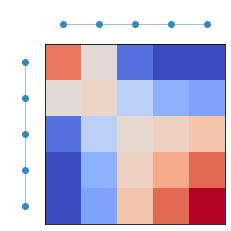

In [413]:
plt.imshow(
    (interaction_sum/interaction_count)[1:-1,1:-1],
    cmap="coolwarm",
    norm = colors.LogNorm(vmin=0.5, vmax=2)
)
fig = plt.gcf()
fig.set_facecolor("white")
ax = plt.gca()
divider = make_axes_locatable(ax)
#
vec = np.asarray([0,0,0,0,0])
#
ax2 = divider.append_axes("top", size="20%", pad=0.02, sharex=ax)
ax2.plot(vec,linewidth=0.5,marker="o")
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.grid(False)
ax2.set_frame_on(False)
ax2.set_xlim(0-0.5,vec.size-0.5)
ymin, ymax = ax2.get_ylim()

ax1 = divider.append_axes("left", size="20%", pad=0.02, sharey=ax)
ax1.plot(vec,np.arange(vec.size),linewidth=0.5,marker="o")
# ax1.fill_betweenx(np.arange(vec.size), vec, np.median(vec), where=(vec >=np.median(vec)),color="red")
# ax1.fill_betweenx(np.arange(vec.size), vec, np.median(vec), where=(vec <=np.median(vec)),color="blue")
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.grid(False)
ax1.set_frame_on(False)
ax1.set_xlim((ymax, ymin))
ax1.set_ylim(vec.size-0.5,0-0.5)
# for fv,tv in vecspans:
#     ax1.axhspan(fv,tv,**vspan_kwd)


## Saddleplots

A common way to visualize preferences captured by the eigenvector is by using saddleplots.

To generate a saddleplot, we first use the eigenvector to stratify genomic regions into groups with similar values of the eigenvector. These groups are then averaged over to create the saddleplot.
This process is called "digitizing".

Cooltools will operate with `digitized` bedgraph-like track with four columns. The fourth, or value, column is a categorical, as shown above for the first three bins. Categories have the following encoding:

    - `1..n` <-> values assigned to bins defined by vrange or qrange
    - `0` <-> left outlier values
    - `n+1` <-> right outlier values
    - `-1` <-> missing data (NaNs)
    
Track values can either be digitized by numeric values, by passing `vrange`, or by quantiles, by passing `qrange`, as above.

To create saddles in cis with `saddle`, cooltools requires: a cooler, a table with expected as function of distance, and parameters for digitizing:

`saddle` then returns two matrices: one with the sum for each pair of categories, `interaction_sum`, and the other with the number of bins for each pair of categories, `interaction_count`. Typically, `interaction_sum`/`interaction_count` is visualized. 


There are multiple ways to plot saddle data, one useful way is shown below. 

This visualization includes histograms of the number of bins contributing to each row/column of the saddleplot.

In [375]:
import warnings
from cytoolz import merge

def saddleplot(
    track,
    saddledata,
    n_bins,
    vrange=None,
    qrange=(0.0, 1.0),
    cmap="coolwarm",
    scale="log",
    vmin=0.5,
    vmax=2,
    color=None,
    title=None,
    xlabel=None,
    ylabel=None,
    clabel=None,
    fig=None,
    fig_kws=None,
    heatmap_kws=None,
    margin_kws=None,
    cbar_kws=None,
    subplot_spec=None,
):
    """
    Generate a saddle plot.
    Parameters
    ----------
    track : pd.DataFrame
        See cooltools.digitize() for details.
    saddledata : 2D array-like
        Saddle matrix produced by `make_saddle`. It will include 2 flanking
        rows/columns for outlier signal values, thus the shape should be
        `(n+2, n+2)`.
    cmap : str or matplotlib colormap
        Colormap to use for plotting the saddle heatmap
    scale : str
        Color scaling to use for plotting the saddle heatmap: log or linear
    vmin, vmax : float
        Value limits for coloring the saddle heatmap
    color : matplotlib color value
        Face color for margin bar plots
    fig : matplotlib Figure, optional
        Specified figure to plot on. A new figure is created if none is
        provided.
    fig_kws : dict, optional
        Passed on to `plt.Figure()`
    heatmap_kws : dict, optional
        Passed on to `ax.imshow()`
    margin_kws : dict, optional
        Passed on to `ax.bar()` and `ax.barh()`
    cbar_kws : dict, optional
        Passed on to `plt.colorbar()`
    subplot_spec : GridSpec object
        Specify a subregion of a figure to using a GridSpec.
    Returns
    -------
    Dictionary of axes objects.
    """

    from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
    from matplotlib.colors import Normalize, LogNorm
    from matplotlib import ticker
    import matplotlib.pyplot as plt

    class MinOneMaxFormatter(ticker.LogFormatter):
        def set_locs(self, locs=None):
            self._sublabels = set([vmin % 10 * 10, vmax % 10, 1])

        def __call__(self, x, pos=None):
            if x not in [vmin, 1, vmax]:
                return ""
            else:
                return "{x:g}".format(x=x)

    track_value_col = track.columns[3]
    track_values = track[track_value_col].values

    digitized_track, binedges = cooltools.digitize(
        track, n_bins, vrange=vrange, qrange=qrange
    )
    x = digitized_track[digitized_track.columns[3]].values.astype(int).copy()
    x = x[(x > -1) & (x < len(binedges) + 1)]
    hist = np.bincount(x, minlength=len(binedges) + 1)
    if qrange is not None:
        lo, hi = qrange
        binedges = np.linspace(lo, hi, n_bins + 1)

    # Histogram and saddledata are flanked by outlier bins
    n = saddledata.shape[0]
    X, Y = np.meshgrid(binedges, binedges)
    C = saddledata
    if (n - n_bins) == 2:
        C = C[1:-1, 1:-1]
        hist = hist[1:-1]

    # Layout
    if subplot_spec is not None:
        GridSpec = partial(GridSpecFromSubplotSpec, subplot_spec=subplot_spec)
    grid = {}
    gs = GridSpec(
        nrows=3,
        ncols=3,
        width_ratios=[0.2, 1, 0.1],
        height_ratios=[0.2, 1, 0.1],
        wspace=0.05,
        hspace=0.05,
    )

    # Figure
    if fig is None:
        fig_kws_default = dict(figsize=(5, 5))
        fig_kws = merge(fig_kws_default, fig_kws if fig_kws is not None else {})
        fig = plt.figure(**fig_kws)

    # Heatmap
    if scale == "log":
        norm = LogNorm(vmin=vmin, vmax=vmax)
    elif scale == "linear":
        norm = Normalize(vmin=vmin, vmax=vmax)
    else:
        raise ValueError("Only linear and log color scaling is supported")

    grid["ax_heatmap"] = ax = plt.subplot(gs[4])
    heatmap_kws_default = dict(cmap="coolwarm", rasterized=True)
    heatmap_kws = merge(
        heatmap_kws_default, heatmap_kws if heatmap_kws is not None else {}
    )
    img = ax.pcolormesh(X, Y, C, norm=norm, **heatmap_kws)
    plt.gca().yaxis.set_visible(False)

    # Margins
    margin_kws_default = dict(edgecolor="k", facecolor=color, linewidth=1)
    margin_kws = merge(margin_kws_default, margin_kws if margin_kws is not None else {})
    # left margin hist
    grid["ax_margin_y"] = plt.subplot(gs[3], sharey=grid["ax_heatmap"])
    plt.barh(
        binedges[:-1], height=np.diff(binedges), width=hist, align="edge", **margin_kws
    )
    plt.xlim(plt.xlim()[1], plt.xlim()[0])  # fliplr
    plt.ylim(hi, lo)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().xaxis.set_visible(False)
    # top margin hist
    grid["ax_margin_x"] = plt.subplot(gs[1], sharex=grid["ax_heatmap"])
    plt.bar(
        binedges[:-1], width=np.diff(binedges), height=hist, align="edge", **margin_kws
    )
    plt.xlim(lo, hi)
    # plt.ylim(plt.ylim())  # correct
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().xaxis.set_visible(False)
    plt.gca().yaxis.set_visible(False)

    # Colorbar
    grid["ax_cbar"] = plt.subplot(gs[5])
    cbar_kws_default = dict(fraction=0.8, label=clabel or "")
    cbar_kws = merge(cbar_kws_default, cbar_kws if cbar_kws is not None else {})
    if scale == "linear" and vmin is not None and vmax is not None:
        grid["cbar"] = cb = plt.colorbar(img, **cbar_kws)
        # cb.set_ticks(np.arange(vmin, vmax + 0.001, 0.5))
        # # do linspace between vmin and vmax of 5 segments and trunc to 1 decimal:
        decimal = 10
        nsegments = 5
        cd_ticks = np.trunc(np.linspace(vmin, vmax, nsegments) * decimal) / decimal
        cb.set_ticks(cd_ticks)
    else:
        grid["cbar"] = cb = plt.colorbar(img, format=MinOneMaxFormatter(), **cbar_kws)
        cb.ax.yaxis.set_minor_formatter(MinOneMaxFormatter())

    # extra settings
    grid["ax_heatmap"].set_xlim(lo, hi)
    grid["ax_heatmap"].set_ylim(hi, lo)
    plt.grid(False)
    plt.axis("off")
    if title is not None:
        grid["ax_margin_x"].set_title(title)
    if xlabel is not None:
        grid["ax_heatmap"].set_xlabel(xlabel)
    if ylabel is not None:
        grid["ax_margin_y"].set_ylabel(ylabel)

    return grid

The saddle below shows average observed/expected contact frequency between regions grouped according to their digitized eigenvector values with a blue-to-white-to-red colormap. Inactive regions (i.e. low digitized values) are on the top and left, and active regions (i.e. high digitized values) are on the bottom and right. 

The saddleplot shows that inactive regions are enriched for contact frequency with other inactive regions (red area in the upper left), and active regions are enriched for contact frequency with other active regions (red area in the lower right). In contrast, active regions are depleted for contact frequency with inactive regions (blue area in top right and bottom left). 

/tmp/ipykernel_8122/2380751830.py:130: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  img = ax.pcolormesh(X, Y, C, norm=norm, **heatmap_kws)
/tmp/ipykernel_8122/2380751830.py:173: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  grid["cbar"] = cb = plt.colorbar(img, format=MinOneMaxFormatter(), **cbar_kws)
/tmp/ipykernel_8122/2380751830.py:173: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  grid["cbar"] = cb = plt.colorbar(img, format=MinOneMaxFormatter(), **cbar_kws)


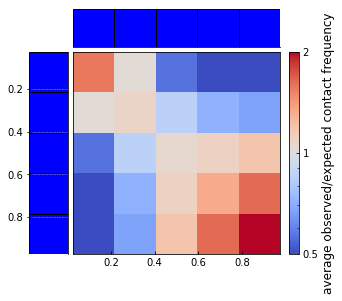

In [376]:
saddleplot(eigenvector_track, 
           interaction_sum/interaction_count,
           N_GROUPS, 
           qrange=(Q_LO,Q_HI), 
           cbar_kws={'label':'average observed/expected contact frequency'}
          );
